In [4]:
import pandas as pd
import os
from Book_module.Book import Book
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [2]:
data = []
stories_folder = 'books'
story_files = [f for f in os.listdir(stories_folder) if f.endswith('.txt')]

#Dictionary mapping story filenames to perpetrators
story_perpetrators = {
    'book_bottomless_well.txt': 'Harrison',
    'book_eye_of_apollo.txt': 'Kevin',
    'book_face_in_the_target.txt' : 'Jenkins',
    'book_fad_of_the_fisherman.txt' : 'Merivale',
    'book_hole_in_the_wall.txt' : 'Haddow',
    'book_secret_garden.txt' : 'Valentin',
    'book_sign_of_the_broken_sword.txt' : 'Arthur',
    'book_soul_of_schoolboy.txt' : 'Morty',
    'book_temple_of_silence.txt' : 'Verner',
    'book_the_blue_cross.txt' : 'Hercule',
    'book_the_flying_stars.txt' : 'Hercule',
    'book_the_hammer_of_god.txt' : 'Wilfred',
    'book_the_queer_feet.txt' : 'Hercule',
    'book_the_sins_of_prince_saradine.txt' : 'Saradine',
    'book_the_wrong_shape.txt' : 'Harris',
    'book_three_tools_of_death.txt' : 'Aaron',
    'book_vanishing_prince.txt' : 'Wilson',
    'book_vengeance_of_the_statue.txt' : 'Horne'
}

for story_file in story_files:
    file_path = os.path.join(stories_folder, story_file)
    book = Book(file_path)
    book.pre_process()
    book.feature_extraction()
    
    #Get the perp for this story
    perpetrator = story_perpetrators.get(story_file)
    if perpetrator is None:
        print(f"No perpetrator found for {story_file}. Skipping.")
        continue
    
    #Features related to the perp
    perp_mention_count = book.character_mentions_all.get(perpetrator, 0)
    perp_first_mention = book.character_mentions_first.get(perpetrator, -1)
    perp_sentiment = book.character_sentiments.get(perpetrator, 0)
    
    #Rank of the perp by mentions
    mentions_sorted = sorted(book.character_mentions_all.items(), key=lambda x: x[1], reverse=True)
    perp_rank = next((rank for rank, (name, _) in enumerate(mentions_sorted, 1) if name == perpetrator), None)
    
    #Total number of characters
    total_characters = len(book.names)
    
    #Average character mention count
    avg_mention_count = sum(book.character_mentions_all.values()) / total_characters if total_characters > 0 else 0
    
    #Crime first introduction
    crime_first_intro = book.crime_first_introduction
    
    #Is the perp introduced before the crime
    perp_introduced_before_crime = perp_first_mention < crime_first_intro if crime_first_intro != -1 else False
    
    #Proximity features
    perp_proximity_score = sum(count for (char1, char2), count in book.character_proximity.items() if perpetrator in (char1, char2))
    
    #Prepare the row data
    row = {
        'Story': story_file,
        'Perpetrator': perpetrator,
        'Perp_Mention_Count': perp_mention_count,
        'Perp_First_Mention': perp_first_mention,
        'Perp_Sentiment': perp_sentiment,
        'Perp_Rank': perp_rank,
        'Total_Characters': total_characters,
        'Avg_Mention_Count': avg_mention_count,
        'Crime_First_Introduction': crime_first_intro,
        'Perp_Introduced_Before_Crime': perp_introduced_before_crime,
        'Perp_Proximity_Score': perp_proximity_score,
    }
    
    data.append(row)

df = pd.DataFrame(data)
print(df.head())

                                  Story Perpetrator  Perp_Mention_Count  \
0                book_secret_garden.txt    Valentin                  50   
1                book_eye_of_apollo.txt       Kevin                  18   
2            book_soul_of_schoolboy.txt       Morty                  13   
3  book_the_sins_of_prince_saradine.txt    Saradine                  33   
4     book_sign_of_the_broken_sword.txt      Arthur                  29   

   Perp_First_Mention  Perp_Sentiment  Perp_Rank  Total_Characters  \
0                   2        0.052329        1.0                10   
1                 166        0.160821        4.0                 6   
2                 532        0.072831        4.0                 6   
3                   2        0.029970        2.0                 7   
4                 350       -0.017970        1.0                 7   

   Avg_Mention_Count  Crime_First_Introduction  Perp_Introduced_Before_Crime  \
0          21.700000                         1  

In [3]:
character_data = []

for story_file in story_files:
    file_path = os.path.join(stories_folder, story_file)
    book = Book(file_path)
    book.pre_process()
    book.feature_extraction()
    
    #Get the perp for this story
    perpetrator = story_perpetrators.get(story_file)
    if perpetrator is None:
        print(f"No perpetrator found for {story_file}. Skipping.")
        continue
    
    for character in book.names:
        #Character-specific features
        mention_count = book.character_mentions_all.get(character, 0)
        first_mention = book.character_mentions_first.get(character, -1)
        sentiment = book.character_sentiments.get(character, 0)
        
        #Rank of the character by mentions
        mentions_sorted = sorted(book.character_mentions_all.items(), key=lambda x: x[1], reverse=True)
        char_rank = next((rank for rank, (name, _) in enumerate(mentions_sorted, 1) if name == character), None)
        
        #Proximity features
        proximity_score = sum(count for (char1, char2), count in book.character_proximity.items() if character in (char1, char2))
        
        #Label 1 if this character is the perp, 0 otherwise
        label = 1 if character == perpetrator else 0

        #Plot phase of First Mention
        first_mention_phase = None
        for phase, (start_idx, end_idx) in book.plot_structure.items():
            if first_mention >= start_idx and first_mention <= end_idx:
                first_mention_phase = phase
                break
        if first_mention_phase is None:
            first_mention_phase = 'Unknown'

        #One-hot encode the plot phase
        plot_phase_features = {
            'First_Mention_Exposition': int(first_mention_phase == 'Exposition'),
            'First_Mention_Rising_Action': int(first_mention_phase == 'Rising Action'),
            'First_Mention_Climax': int(first_mention_phase == 'Climax'),
            'First_Mention_Falling_Action': int(first_mention_phase == 'Falling Action'),
            'First_Mention_Resolution': int(first_mention_phase == 'Resolution'),
            'First_Mention_Unknown': int(first_mention_phase == 'Unknown'),
        }

        #Mentions per plot phase
        mentions_per_phase = {
            'Exposition': 0,
            'Rising Action': 0,
            'Climax': 0,
            'Falling Action': 0,
            'Resolution': 0,
            'Unknown': 0,
        }

        #Map sentence indices to plot phases
        sentence_plot_phases = {}
        for phase, (start_idx, end_idx) in book.plot_structure.items():
            for idx in range(start_idx, end_idx + 1):
                sentence_plot_phases[idx] = phase

        #Count mentions per plot phase
        for idx, sentence in enumerate(book.sentences):
            phase = sentence_plot_phases.get(idx, 'Unknown')
            if character in sentence:
                mentions_per_phase[phase] += 1

        #Add mentions per phase to the features
        total_mentions = sum(mentions_per_phase.values())
        if total_mentions > 0:
            mentions_proportion = {
                f'Mentions_{phase}_Proportion': count / total_mentions
                for phase, count in mentions_per_phase.items()
            }
        else:
            mentions_proportion = {
                f'Mentions_{phase}_Proportion': 0
                for phase in mentions_per_phase.keys()
            }
        
        #Prepare the row data
        row = {
            'Story': story_file,
            'Character': character,
            'Label': label,
            'Mention_Count': mention_count,
            'First_Mention': first_mention,
            'Sentiment': sentiment,
            'Rank': char_rank,
            'Proximity_Score': proximity_score,
        }

        #Add the plot phase features
        row.update(plot_phase_features)
        row.update(mentions_proportion)
        
        character_data.append(row)

#Create the df
character_df = pd.DataFrame(character_data)
character_df.fillna(0, inplace=True)
print(character_df.head())

                    Story Character  Label  Mention_Count  First_Mention  \
0  book_secret_garden.txt      Ivan      0             25             15   
1  book_secret_garden.txt  Valentin      1             50              2   
2  book_secret_garden.txt      Gina      0              6            240   
3  book_secret_garden.txt     Simon      0             23            271   
4  book_secret_garden.txt      Paul      0             24            292   

   Sentiment  Rank  Proximity_Score  First_Mention_Exposition  \
0  -0.014336     4               57                         0   
1   0.052329     1               38                         0   
2   0.172943     9               29                         0   
3  -0.081121     6               49                         0   
4  -0.055629     5               52                         0   

   First_Mention_Rising_Action  First_Mention_Climax  \
0                            1                     0   
1                            1          

In [7]:
#Select features and target
features = [
    'Mention_Count', 'First_Mention', 'Sentiment', 'Rank', 'Proximity_Score',
    'First_Mention_Exposition', 'First_Mention_Rising_Action', 'First_Mention_Climax',
    'First_Mention_Falling_Action', 'First_Mention_Resolution', 'First_Mention_Unknown',
    'Mentions_Exposition_Proportion', 'Mentions_Rising Action_Proportion',
    'Mentions_Climax_Proportion', 'Mentions_Falling Action_Proportion',
    'Mentions_Resolution_Proportion', 'Mentions_Unknown_Proportion',
]

x = character_df[features]
y = character_df['Label']
x = x.fillna(0)

#Split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=1)

#Apply SMOTE to training data to try to make perp to non-perp even
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x_train, y_train)

#Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

#Train the model
model.fit(x_resampled, y_resampled)

#Predict on the test set
y_pred = model.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        20
           1       0.33      0.33      0.33         3

    accuracy                           0.83        23
   macro avg       0.62      0.62      0.62        23
weighted avg       0.83      0.83      0.83        23



In [8]:
#Testing to see how the model does on a book in the training set
new_story_path = 'books/book_bottomless_well.txt'
new_book = Book(new_story_path)

#Process the book
new_book.pre_process()
new_book.feature_extraction()

In [11]:
#Extract features
new_character_data = []
for character in new_book.names:
    #Character-specific features
    mention_count = new_book.character_mentions_all.get(character, 0)
    first_mention = new_book.character_mentions_first.get(character, -1)
    sentiment = new_book.character_sentiments.get(character, 0)

    #Rank of the character by mentions
    mentions_sorted = sorted(new_book.character_mentions_all.items(), key=lambda x: x[1], reverse=True)
    char_rank = next((rank for rank, (name, _) in enumerate(mentions_sorted, 1) if name == character), None)

    #Proximity features
    proximity_score = sum(count for (char1, char2), count in new_book.character_proximity.items() if character in (char1, char2))

    #Prepare the row data
    row = {
        'Character': character,
        'Mention_Count': mention_count,
        'First_Mention': first_mention,
        'Sentiment': sentiment,
        'Rank': char_rank,
        'Proximity_Score': proximity_score,
    }

    #Plot phase of first mention
    first_mention_phase = None
    if hasattr(new_book, 'plot_structure'):
        for phase, (start_idx, end_idx) in new_book.plot_structure.items():
            if first_mention >= start_idx and first_mention <= end_idx:
                first_mention_phase = phase
                break
    if first_mention_phase is None:
        first_mention_phase = 'Unknown'

    #One-hot encode the plot phase
    plot_phase_features = {
        'First_Mention_Exposition': int(first_mention_phase == 'Exposition'),
        'First_Mention_Rising_Action': int(first_mention_phase == 'Rising Action'),
        'First_Mention_Climax': int(first_mention_phase == 'Climax'),
        'First_Mention_Falling_Action': int(first_mention_phase == 'Falling Action'),
        'First_Mention_Resolution': int(first_mention_phase == 'Resolution'),
        'First_Mention_Unknown': int(first_mention_phase == 'Unknown'),
    }

    #Mentions per plot phase
    mentions_per_phase = {
        'Exposition': 0,
        'Rising Action': 0,
        'Climax': 0,
        'Falling Action': 0,
        'Resolution': 0,
        'Unknown': 0,
    }

    #Map sentence indices to plot phases
    sentence_plot_phases = {}
    if hasattr(new_book, 'plot_structure'):
        for phase, (start_idx, end_idx) in new_book.plot_structure.items():
            for idx in range(start_idx, end_idx + 1):
                sentence_plot_phases[idx] = phase
    else:
        # If plot_structure is not available, assign 'Unknown' to all sentences
        for idx in range(len(new_book.sentences)):
            sentence_plot_phases[idx] = 'Unknown'

    #Count mentions per plot phase
    for idx, sentence in enumerate(new_book.sentences):
        phase = sentence_plot_phases.get(idx, 'Unknown')
        if character in sentence:
            mentions_per_phase[phase] += 1

    #Add mentions per phase to the features
    total_mentions = sum(mentions_per_phase.values())
    if total_mentions > 0:
        mentions_proportion = {
            f'Mentions_{phase}_Proportion': mentions_per_phase[phase] / total_mentions
            for phase in mentions_per_phase.keys()
        }
    else:
        mentions_proportion = {
            f'Mentions_{phase}_Proportion': 0
            for phase in mentions_per_phase.keys()
        }

    #Add the plot phase features
    row.update(plot_phase_features)
    row.update(mentions_proportion)

    new_character_data.append(row)

new_character_df = pd.DataFrame(new_character_data)

features = [
    'Mention_Count', 'First_Mention', 'Sentiment', 'Rank', 'Proximity_Score',
    'First_Mention_Exposition', 'First_Mention_Rising_Action', 'First_Mention_Climax',
    'First_Mention_Falling_Action', 'First_Mention_Resolution', 'First_Mention_Unknown',
    'Mentions_Exposition_Proportion', 'Mentions_Rising Action_Proportion',
    'Mentions_Climax_Proportion', 'Mentions_Falling Action_Proportion',
    'Mentions_Resolution_Proportion', 'Mentions_Unknown_Proportion',
]

#Handle missing features
for feature in features:
    if feature not in new_character_df.columns:
        new_character_df[feature] = 0  # or appropriate default value

x_new = new_character_df[features].fillna(0)


In [13]:
y_pred_proba = model.predict_proba(x_new)

#Get the probability of each character being the perp
new_character_df['Perpetrator_Probability'] = y_pred_proba[:, 1]

#Predict class labels
y_pred = model.predict(x_new)
new_character_df['Predicted_Label'] = y_pred

print(new_character_df[['Character', 'Perpetrator_Probability', 'Predicted_Label']])


  Character  Perpetrator_Probability  Predicted_Label
0     Boyle                     0.12                0
1  Harrison                     0.93                1
2     Horne                     0.11                0
3       Tom                     0.10                0
4    Grayne                     0.06                0


In [14]:
#Sort characters by predicted probability
sorted_predictions = new_character_df.sort_values(by='Perpetrator_Probability', ascending=False)
print(sorted_predictions[['Character', 'Perpetrator_Probability', 'Predicted_Label']])
actual_perpetrator = 'Harrison'

#Check if the model predicted correctly
if actual_perpetrator in sorted_predictions['Character'].values:
    predicted_prob = sorted_predictions.loc[sorted_predictions['Character'] == actual_perpetrator, 'Perpetrator_Probability'].values[0]
    predicted_label = sorted_predictions.loc[sorted_predictions['Character'] == actual_perpetrator, 'Predicted_Label'].values[0]
    print(f"Actual Perpetrator: {actual_perpetrator}")
    print(f"Model's Predicted Probability: {predicted_prob}")
    print(f"Model's Predicted Label: {predicted_label}")
else:
    print(f"Actual Perpetrator {actual_perpetrator} not found among extracted characters.")


  Character  Perpetrator_Probability  Predicted_Label
1  Harrison                     0.93                1
0     Boyle                     0.12                0
2     Horne                     0.11                0
3       Tom                     0.10                0
4    Grayne                     0.06                0
Actual Perpetrator: Harrison
Model's Predicted Probability: 0.93
Model's Predicted Label: 1


In [16]:
#Identify false positives
false_positives = sorted_predictions[(sorted_predictions['Predicted_Label'] == 1) & (sorted_predictions['Character'] != actual_perpetrator)]
print("False Positives:")
print(false_positives[['Character', 'Perpetrator_Probability']])

#Identify the actual perp's prediction
actual_perp_prediction = sorted_predictions[sorted_predictions['Character'] == actual_perpetrator]
print("Actual Perpetrator's Prediction:")
print(actual_perp_prediction[['Character', 'Perpetrator_Probability', 'Predicted_Label']])


False Positives:
Empty DataFrame
Columns: [Character, Perpetrator_Probability]
Index: []
Actual Perpetrator's Prediction:
  Character  Perpetrator_Probability  Predicted_Label
1  Harrison                     0.93                1


In [17]:
#Features of the actual perp
actual_perp_features = new_character_df[new_character_df['Character'] == actual_perpetrator]
print("Actual Perpetrator's Features:")
print(actual_perp_features[features + ['Perpetrator_Probability', 'Predicted_Label']])

#Features of top predicted perp
top_predictions = sorted_predictions.head(5)
print("Top Predicted Characters' Features:")
print(top_predictions[['Character'] + features + ['Perpetrator_Probability', 'Predicted_Label']])


Actual Perpetrator's Features:
   Mention_Count  First_Mention  Sentiment  Rank  Proximity_Score  \
1             14            289   0.037757     5               39   

   First_Mention_Exposition  First_Mention_Rising_Action  \
1                         0                            0   

   First_Mention_Climax  First_Mention_Falling_Action  \
1                     0                             0   

   First_Mention_Resolution  First_Mention_Unknown  \
1                         1                      0   

   Mentions_Exposition_Proportion  Mentions_Rising Action_Proportion  \
1                             0.0                           0.071429   

   Mentions_Climax_Proportion  Mentions_Falling Action_Proportion  \
1                         0.0                            0.714286   

   Mentions_Resolution_Proportion  Mentions_Unknown_Proportion  \
1                        0.142857                     0.071429   

   Perpetrator_Probability  Predicted_Label  
1                     

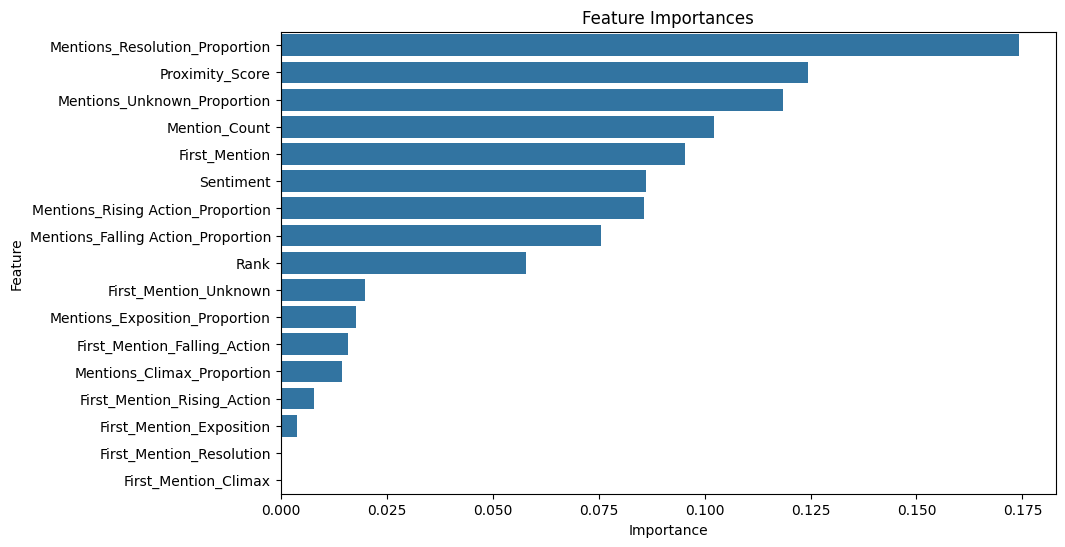

In [18]:
#Get feature importances from the model
feature_importances = model.feature_importances_
feature_names = features
feat_importances = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feat_importances = feat_importances.sort_values(by='Importance', ascending=False)

#Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importances)
plt.title('Feature Importances')
plt.show()


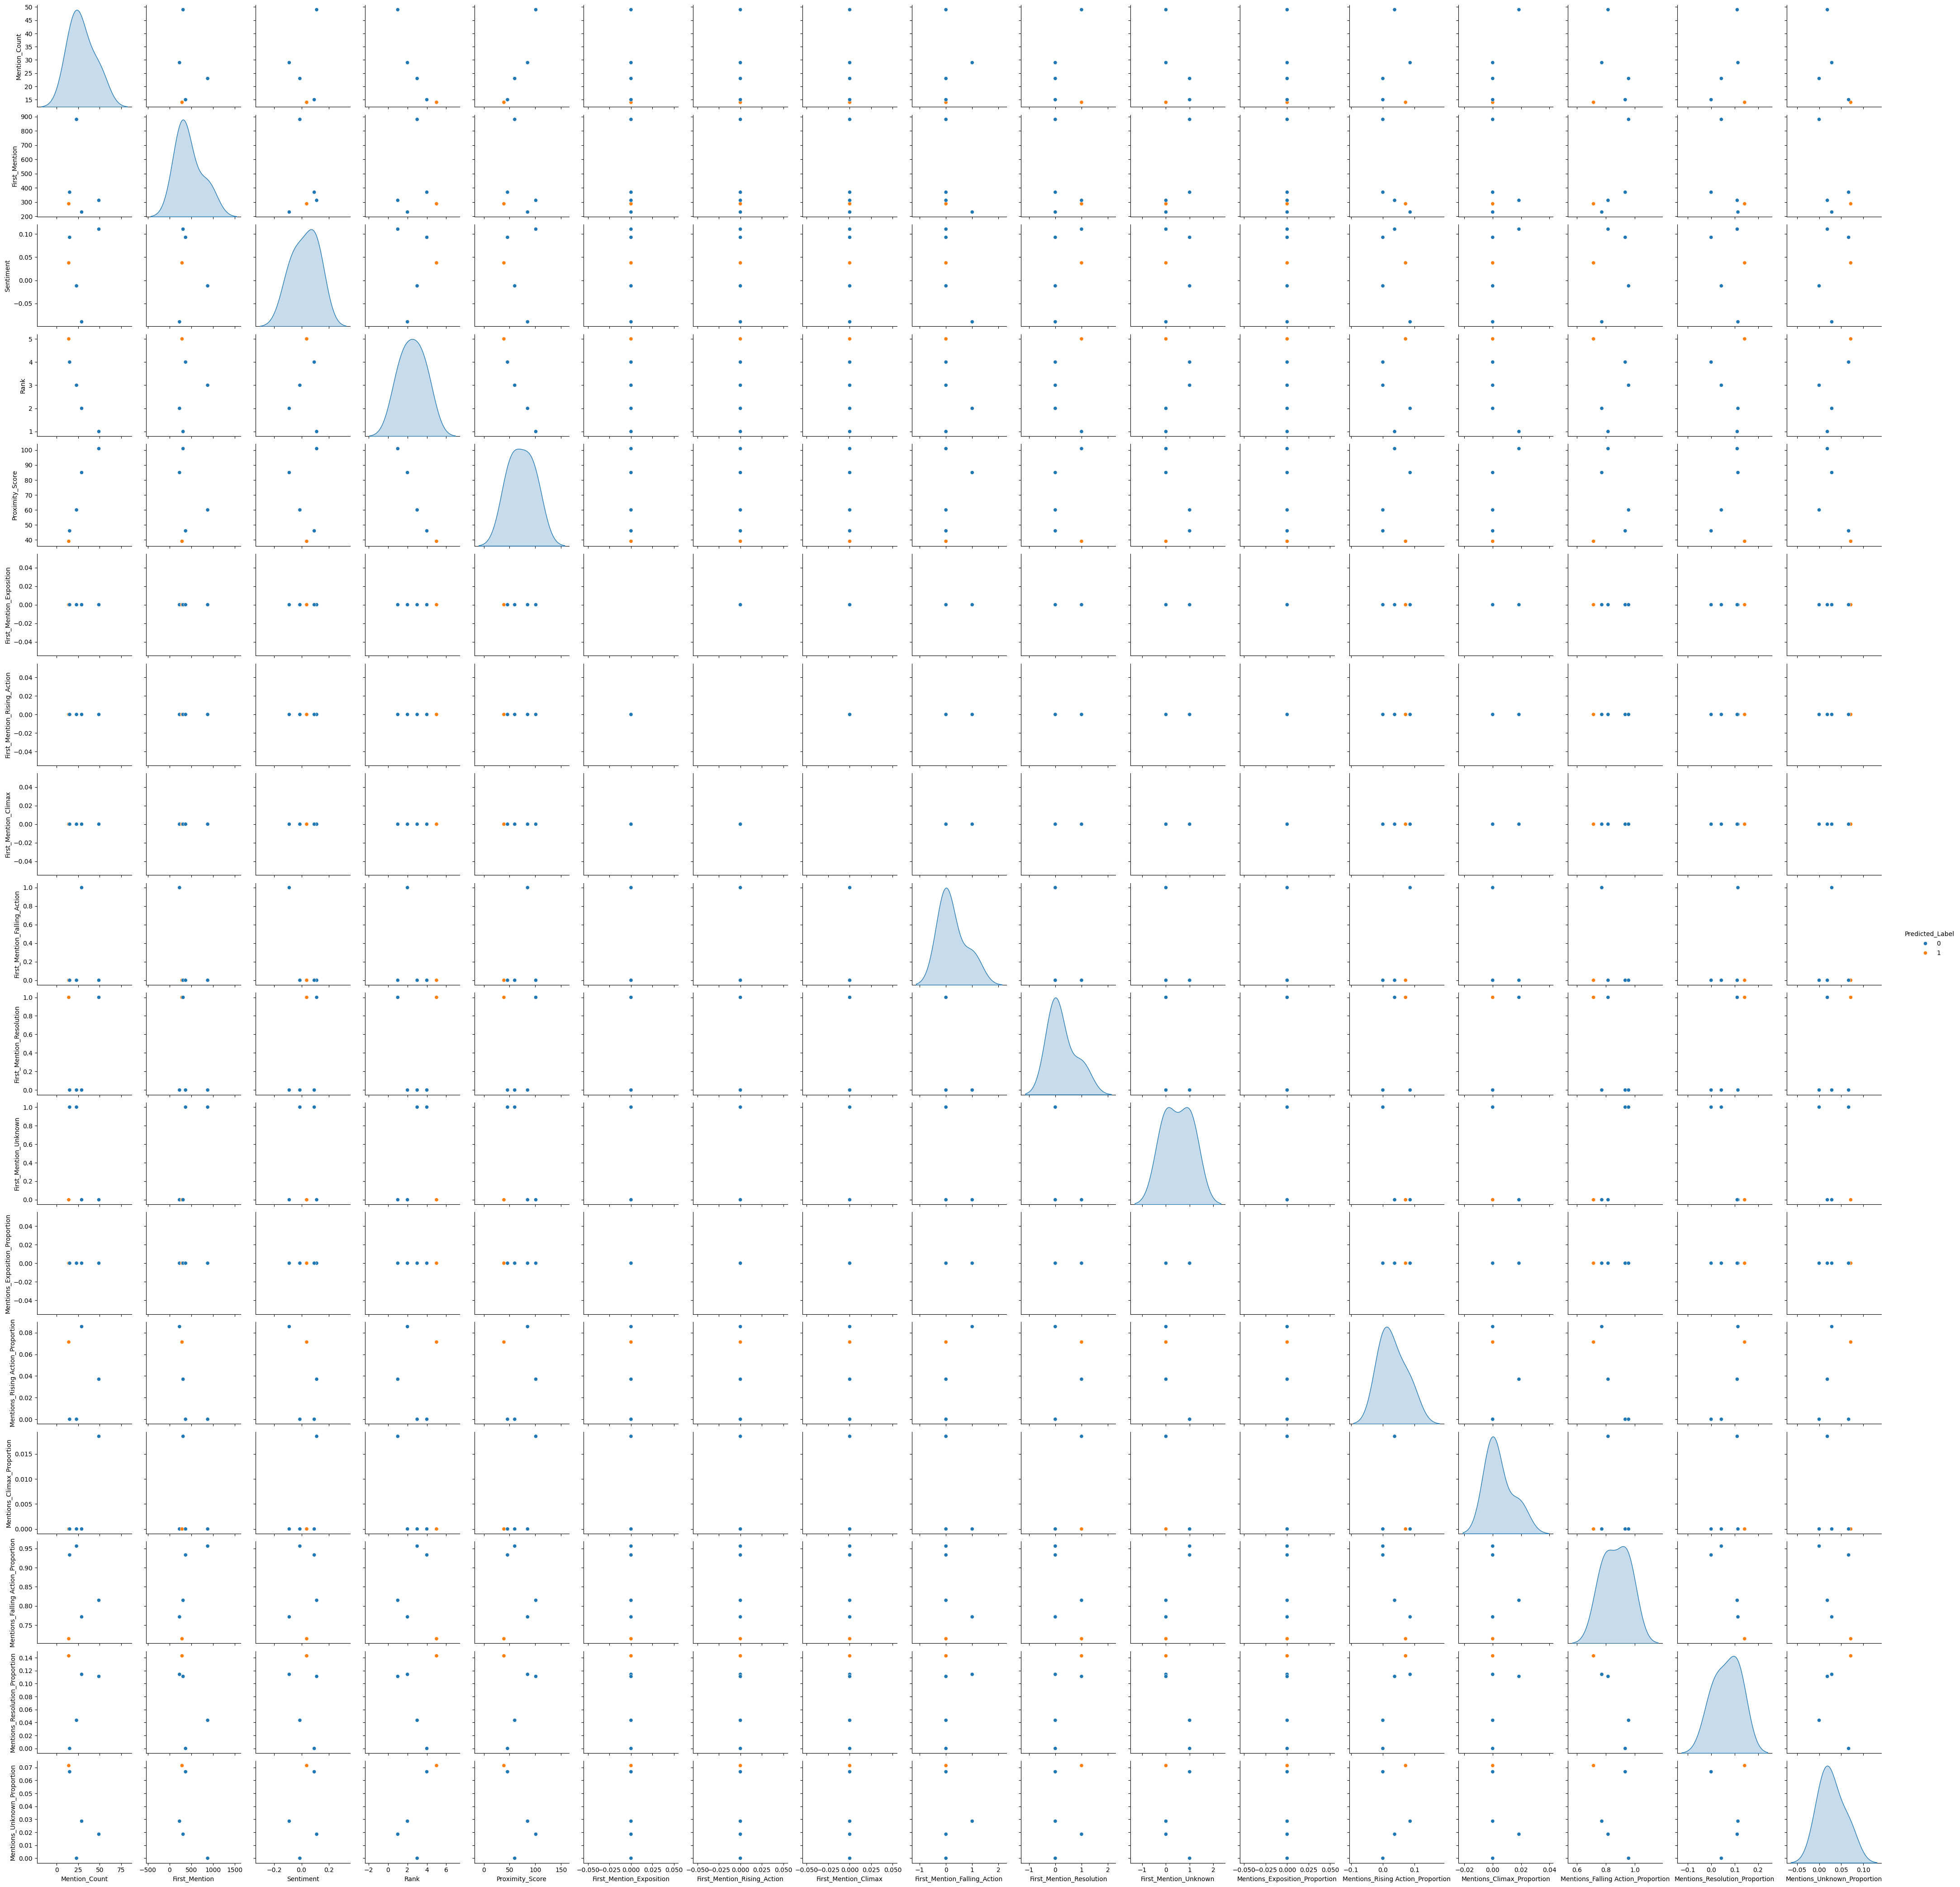

In [13]:
#Compare feature distributions, AKA supergraph
sns.pairplot(new_character_df, vars=features, hue='Predicted_Label')
plt.show()
